In [2]:
import matplotlib.pyplot as plt
import numpy as np
class Optimize:
    def __init__(self):
        self.methods_to_choose_step = {
            "naive": self.naive,
            "newton": self.newton,
            "golden": self.golden,
            "built": self.built_min,
        }
        self.methods_to_choose_direction = {
            "CG": self.reset,
            "GD": self.antigradient,
        }

    def derivative(self, function, x, dx=1e-6, order=1):
        if order == 0:
            return function(x)

        return (self.derivative(function, x + dx, dx, order - 1) - self.derivative(function, x, dx, order - 1)) / dx
#метод скорейшего градиентного спуска
    def gradient(self, x, dx=1e-6):
        dim = x.shape[0]
        grad = np.zeros(x.shape)
        for i in range(dim):
            right = x.copy().astype(float)
            right[i, :] = right[i, :] + dx
            grad[i, :] = (self.function(right) - self.function(x)) / dx

        return grad

    def __call__(self, function, x0, method, threshold=None, iters_num=None, visualize=False, **kwargs):
        self.function = function
        step = self.methods_to_choose_step["built"]
        Direction = self.methods_to_choose_direction[method]

        period = None
        if method == "CG":
            period = kwargs["period"]

        counter = 0
        args = None
        func = None
        steps = None
        dirs = None
        if visualize:
            args = np.array(x0.T)
            func = np.array([function(x0)])
            steps = np.zeros(1)
            dirs = np.array([])

        x = x0
        extr = x
        if (threshold and iters_num) or (not threshold and not iters_num):
            raise Exception("You must specify either number of iterations or threshold.")

        if not threshold:
            direction = - self.gradient(extr)
            for i in range(iters_num):
                if np.linalg.norm(self.gradient(extr)) == 0:
                    break

                direction = Direction(x=x, x_next=extr, direction=direction, iteration=i, period=period)
                s = step(extr, direction)
                if s == 0:
                    #                     print("Zero step")
                    break
                x = extr
                extr = x + s * direction

                if visualize:
                    args = np.vstack((args, extr.T))
                    func = np.append(func, function(extr))
                    steps = np.append(steps, s)
                    dirs = np.append(dirs, np.linalg.norm(direction))
                    counter += 1

        elif not iters_num:
            direction = -self.gradient(extr)
            i = 0
            while np.linalg.norm(self.gradient(extr)) > threshold:
                direction = Direction(x=x, x_next=extr, direction=direction, iteration=i, period=period)
                s = step(extr, direction)
                if s == 0:
                    #                     print("Zero step")
                    break

                x = extr
                extr = x + s * direction
                i += 1

                if visualize:
                    args = np.vstack((args, extr.T))
                    func = np.append(func, function(extr))
                    steps = np.append(steps, s)
                    dirs = np.append(dirs, np.linalg.norm(direction))
                    counter += 1

        if visualize:
            print(f"\nTotal number of steps: {counter}\n" +
                  f"Found extrema: ~({round(extr[0, 0], 3)}, {round(extr[1, 0], 3)})\n" +
                  f"Function value in extrema: ~{round(float(np.squeeze(function(extr))), 3)}\n")

            if counter > 0:
                x = np.array([p[0] for p in args])
                y = np.array([p[1] for p in args])

                gridsize = (3, 5)
                fig = plt.figure(figsize=(20, 12))
                ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3, rowspan=3,
                                       projection="3d")  # add_subplot(221, projection='3d')
                ax3 = plt.subplot2grid(gridsize, (0, 3), colspan=2, rowspan=2)  # add_subplot(222)
                ax2 = plt.subplot2grid(gridsize, (2, 3), colspan=1, rowspan=1,
                                       title="Step")  # add_subplot(223, title="Steps")
                ax4 = plt.subplot2grid(gridsize, (2, 4), colspan=1, rowspan=1,
                                       title="Function descent")  # add_subplot(224, title="Function descent")
                ax2.grid(True)
                ax4.grid(True)

                bound = max(np.max(np.abs(extr)), np.max(np.abs(x0))) + 1  # max(np.max(np.abs(x)), np.max(np.abs(y)))
                X = np.linspace(-bound, bound, 100)
                Y = np.linspace(-bound, bound, 100)
                Z = np.zeros((X.shape[0], Y.shape[0]))
                X, Y = np.meshgrid(X, Y)
                for i in range(X.shape[0]):
                    for j in range(X.shape[0]):
                        Z[i, j] = function(np.asarray((X[i, j], Y[i, j])))

                ax1.view_init(60, -30)
                ax1.plot_surface(X, Y, Z, cmap="jet", alpha=0.5)
                ax1.plot(x, y, func, "black")

                ax2.plot(np.arange(1, counter + 1), steps[1:])
                ax4.plot(np.arange(counter + 1), func)

                cp = ax3.contour(X, Y, Z, 10)
                plt.clabel(cp, inline=1, fontsize=10)
                ax3.plot(x, y, "-o")

        return extr

    ########################################
    ### Methods to choose step:
    ########################################

    def naive(self, x, direction):
        steps = np.arange(.0, 1, .001)
        func = np.vectorize(lambda p: self.function(x + p * direction))
        f = func(steps)
        minima_idx = np.argsort(f)[0]

        return steps[minima_idx]
# метод Ньютона
    def newton(self, X, direction, threshold=None, iters_num=100):
        f = lambda p: self.function(X + p * direction)
        x = 0
        x_new = x

        if (threshold and iters_num) or (not threshold and not iters_num):
            raise Exception("You must specify either number of iterations or threshold.")

        if not threshold:
            for i in range(iters_num):
                der1 = self.derivative(f, x)
                der2 = self.derivative(f, x, order=2)
                assert (der2 != 0)

                x_new = x - der1 / der2

        elif not iters_num:
            der1 = self.derivative(f, x)
            while abs(der1) > threshold:
                der2 = self.derivative(f, x, order=2)
                assert (der2 != 0)

                x_new = x - der1 / der2
                der1 = self.derivative(f, x)

        return x_new
#метод золотого сечения
    def golden(self, x, direction, threshold=1e-6, iters_num=None):
        f = lambda p: np.squeeze(self.function(x + p * direction))
        alpha = (3 - np.sqrt(5)) / 2
        a = 0
        b = 1
        x1 = a + alpha * (b - a)
        x2 = a + b - x1
        x_new = 0

        if (threshold and iters_num) or (not threshold and not iters_num):
            raise Exception("You must specify either number of iterations or threshold.")

        if not threshold:
            for i in range(iters_num):
                if f(x1) <= f(x2):
                    b = x2
                    x1 = a + b - x1
                    x2 = x1
                else:
                    a = x1
                    x1 = x2
                    x2 = a + b - x2

                x_new = (a + b) / 2

        elif not iters_num:
            while b - a > threshold:
                if f(x1) <= f(x2):
                    b = x2
                    x1 = a + b - x1
                    x2 = x1
                else:
                    a = x1
                    x1 = x2
                    x2 = a + b - x2

                delta = x_new - (a + b) / 2
                x_new = (a + b) / 2

        return x_new

    def built_min(self, x, direction):
        from scipy.optimize import minimize

        f = lambda p: np.squeeze(self.function(x + p * direction))
        return minimize(f, 0, bounds=[(0, np.inf)]).x

    ########################################
    ### Methods to choose direction:
    ########################################

    def antigradient(self, **kwargs):
        x = kwargs["x_next"]

        return - self.gradient(x)

    def reset(self, **kwargs):
        x = kwargs["x"]
        x_next = kwargs["x_next"]
        direction = kwargs["direction"]
        iteration = kwargs["iteration"]
        period = kwargs["period"]

        next_dir = None
        if 1 - ((iteration + 1) % period):
            aux1 = - self.gradient(x)
            aux2 = - self.gradient(x_next)
            coeff = np.dot(aux2.T, aux1) / np.dot(aux1.T, aux1) - 1
            next_dir = aux2 + coeff * direction
        else:
            next_dir = - self.gradient(x_next)

        return next_dir

In [6]:
import math
minimize = Optimize()
himm = lambda x: (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2
eckly = lambda x: (-20.0 * math.exp(-0.2 * math.sqrt(0.5 * (x[0]**2 + x[1]**2))) - math.exp(0.5 * (math.cos(2 * math.pi * x[0]) + math.cos(2 * math.pi * x[1]))) + math.e + 20)



Total number of steps: 412
Found extrema: ~(3.0, 2.0)
Function value in extrema: ~0.0



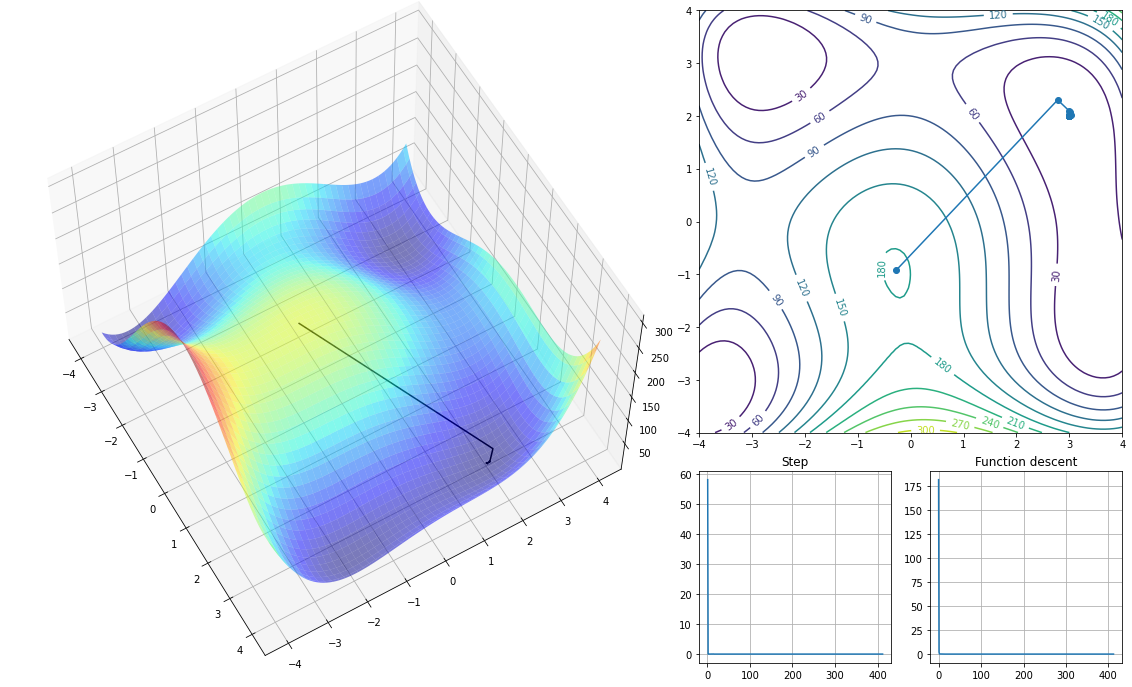

In [15]:
start = np.array([[-0.27], [-0.92]])

a = minimize(himm, start, method="CG", threshold=1e-6, visualize=True)


Total number of steps: 1
Found extrema: ~(-0.0, -0.0)
Function value in extrema: ~0.0



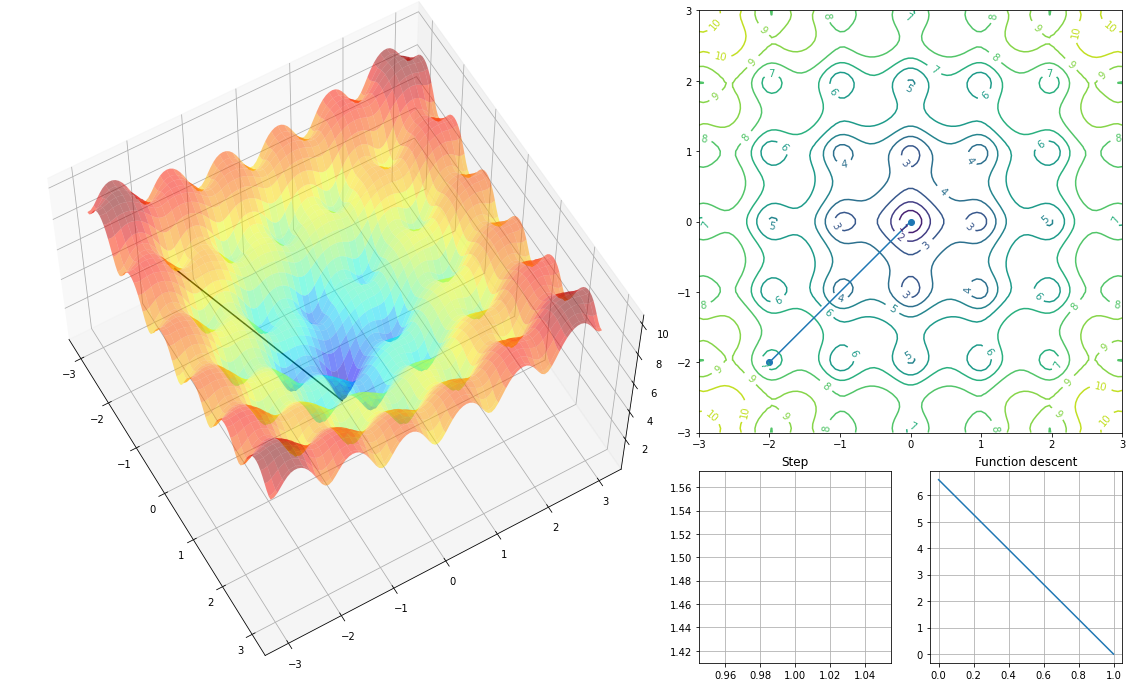

In [8]:
start = -2 * np.ones((2, 1))

a = minimize(eckly, start, method="GD", threshold=1e-6, period=2, visualize=True)